In [63]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from math import pi


In [2]:
#Importando Dados do Big Query

## Importação de Dados do Big Query

### Autenticação

In [3]:
#Importando Dados do Big Query
from google.cloud import bigquery
from google.api_core import exceptions

key_path = "keyfile.json"

try:
    client = bigquery.Client.from_service_account_json(key_path)

    print(f"Autenticação bem-sucedida com o projeto: {client.project}")

except FileNotFoundError:
    print(f"ERRO: O arquivo de chave não foi encontrado no caminho especificado: {key_path}")
    print("Verifique se o caminho está correto.")
    exit()
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a autenticação: {e}")
    exit()


Autenticação bem-sucedida com o projeto: viitra-redu


### Consulta

In [4]:
data_inicio = '2020-01-01'
data_fim = '2021-12-31'

sql_query = f"""
select
     eng.cliente
    ,eng.user_id
    ,eng.environment_id
    ,eng.course_id
    ,eng.space_id
    ,eng.subject_id
    ,eng.lecture_id
    ,eng.NivelAgregacao
    ,eng.user_name
    ,eng.environment_name
    ,eng.course_name
    ,eng.space_name
    ,eng.subject_name
    ,eng.lecture_name
    ,eng.period_start_date
    ,eng.period_end_date
    ,eng.postsAmount
    ,eng.postRepliesAmount
    ,eng.helpRequestsAmount
    ,eng.helpRequestRepliesAmount
    ,eng.performance_rate
from analytics.fn_engajamento(
  DATE('{data_inicio}'),
  DATE('{data_fim}'),
  TRUE,'redu-digital',
  73,
  NULL,
  NULL,
  NULL,
  NULL,'SPA', 'QUARTER'
) as eng
inner join (
    select 
        uea.user_id
        ,uea.cliente 
    from replicas.user_environment_associations uea 
    where uea.role not in ('teacher', 'tutor', 'environment_admin')
) as filtro on filtro.cliente = eng.cliente and filtro.user_id = eng.user_id
"""
try:
    dataframe = client.query(sql_query).to_dataframe()
    print(dataframe.head())
except exceptions.Forbidden as e:
    print(f"ERRO DE PERMISSÃO: {e}")
    print("A autenticação funcionou, mas a conta de serviço não tem permissão para acessar os dados.")
    print("Verifique os papéis de IAM (ex: 'BigQuery User') no Google Cloud Console.")

c:\Users\Matheus Monte\Documents\Classificador\env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital      458              73        155       534        <NA>   
1  redu-digital      688              73        155       534        <NA>   
2  redu-digital      655              73        155       534        <NA>   
3  redu-digital      684              73        155       534        <NA>   
4  redu-digital      684              73        155       534        <NA>   

   lecture_id NivelAgregacao                         user_name  \
0        <NA>            SPA  SILVIO FERREIRA PASSOS GONCALVES   
1        <NA>            SPA         JULIANNE SIQUEIRA PEREIRA   
2        <NA>            SPA   AIRTON HERMOGENES DO NASCIMENTO   
3        <NA>            SPA  IRENICE NOGUEIRA DOS SANTOS ALEX   
4        <NA>            SPA  IRENICE NOGUEIRA DOS SANTOS ALEX   

  environment_name  ...                                 space_name  \
0         SENAC-PE  ...  4. Design de experiências de aprendizagem   


## Análise Exploratória

In [5]:
print(dataframe.head())
dataframe.info()

        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital      458              73        155       534        <NA>   
1  redu-digital      688              73        155       534        <NA>   
2  redu-digital      655              73        155       534        <NA>   
3  redu-digital      684              73        155       534        <NA>   
4  redu-digital      684              73        155       534        <NA>   

   lecture_id NivelAgregacao                         user_name  \
0        <NA>            SPA  SILVIO FERREIRA PASSOS GONCALVES   
1        <NA>            SPA         JULIANNE SIQUEIRA PEREIRA   
2        <NA>            SPA   AIRTON HERMOGENES DO NASCIMENTO   
3        <NA>            SPA  IRENICE NOGUEIRA DOS SANTOS ALEX   
4        <NA>            SPA  IRENICE NOGUEIRA DOS SANTOS ALEX   

  environment_name  ...                                 space_name  \
0         SENAC-PE  ...  4. Design de experiências de aprendizagem   


In [6]:
dataframe.describe()

,user_id,environment_id,course_id,space_id,subject_id,lecture_id,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,13856.0,13856.0,13856.0,13856.0,0.0,0.0,13856.0,13856.0,13856.0,13856.0,13856.000000
mean,1246.944573,73.0,155.0,330.0,<NA>,<NA>,0.262341,0.023456,0.001371,0.002309,0.076483
std,2534.517551,0.0,0.0,198.711725,<NA>,<NA>,1.378585,0.294957,0.040721,0.067926,0.232054
min,448.0,73.0,155.0,120.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
25%,549.0,73.0,155.0,137.25,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
50%,668.0,73.0,155.0,333.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
75%,790.0,73.0,155.0,525.75,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
max,19033.0,73.0,155.0,534.0,<NA>,<NA>,27.0,12.0,2.0,4.0,1.000000


In [7]:
valores_set = dataframe.iloc[:, 16:]

In [8]:
valores_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  Int64  
 1   postRepliesAmount         13856 non-null  Int64  
 2   helpRequestsAmount        13856 non-null  Int64  
 3   helpRequestRepliesAmount  13856 non-null  Int64  
 4   performance_rate          13856 non-null  float64
dtypes: Int64(4), float64(1)
memory usage: 595.5 KB


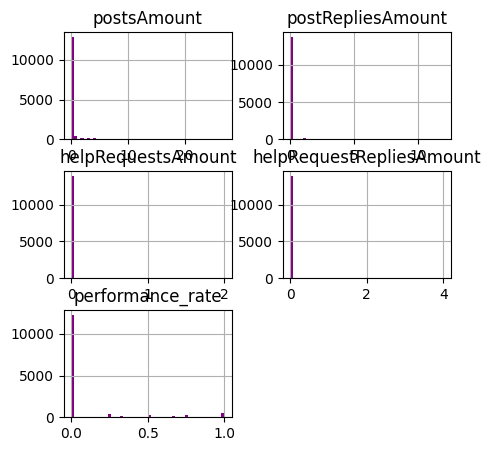

In [9]:
valores_set.hist(bins=50, figsize=(5, 5), color='purple')
plt.show()

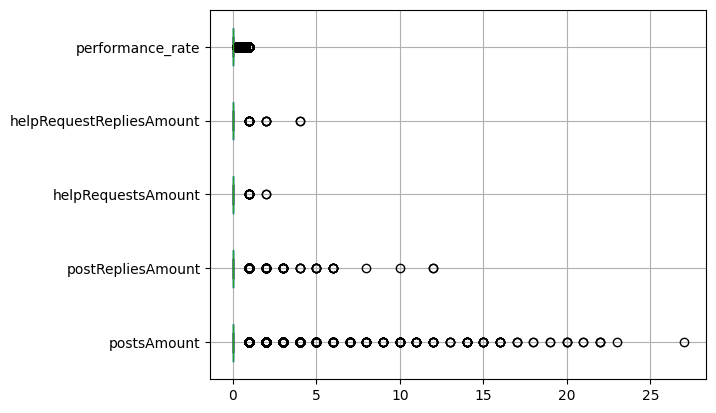

In [10]:
valores_set.boxplot(vert=False)
plt.show()

### Pré-Processamento

In [11]:
train_set = valores_set.copy()
train_set.shape

(13856, 5)

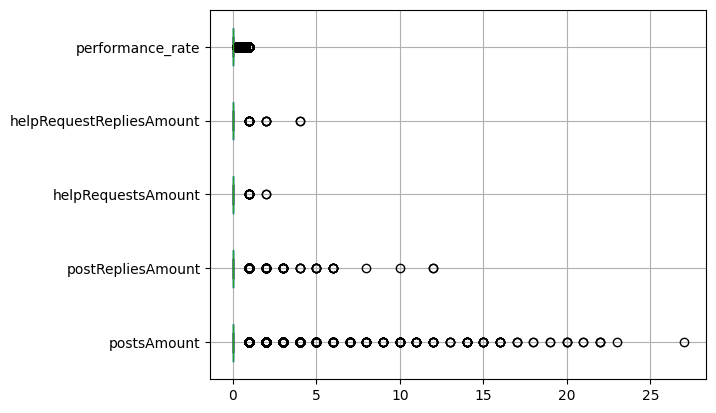

In [12]:
train_set.boxplot(vert=False)
plt.show()

In [13]:
train_set.info()
train_set.describe()
train_set.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  Int64  
 1   postRepliesAmount         13856 non-null  Int64  
 2   helpRequestsAmount        13856 non-null  Int64  
 3   helpRequestRepliesAmount  13856 non-null  Int64  
 4   performance_rate          13856 non-null  float64
dtypes: Int64(4), float64(1)
memory usage: 595.5 KB


,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
0,0,0,0,0,0.0
1,0,0,0,0,0.0
2,0,0,0,0,0.0
3,0,0,0,0,0.0
4,0,0,0,0,0.0


#### Tratando Valores Faltantes

In [14]:
inputer = KNNImputer(n_neighbors=5)
inputer.fit(train_set)

,missing_values,nan
,n_neighbors,5
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


In [15]:
train_set_inpute = inputer.transform(train_set)

In [16]:
train_set_inputado = pd.DataFrame(
    train_set_inpute,
    columns=train_set.columns,
    index=train_set.index
)

In [17]:
train_set = train_set_inputado.copy()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  float64
 1   postRepliesAmount         13856 non-null  float64
 2   helpRequestsAmount        13856 non-null  float64
 3   helpRequestRepliesAmount  13856 non-null  float64
 4   performance_rate          13856 non-null  float64
dtypes: float64(5)
memory usage: 541.4 KB


In [18]:
train_set.describe()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,13856.000000,13856.000000,13856.000000,13856.000000,13856.000000
mean,0.262341,0.023456,0.001371,0.002309,0.076483
std,1.378585,0.294957,0.040721,0.067926,0.232054
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,27.000000,12.000000,2.000000,4.000000,1.000000


In [19]:
print(train_set.columns)

Index(['postsAmount', 'postRepliesAmount', 'helpRequestsAmount',
       'helpRequestRepliesAmount', 'performance_rate'],
      dtype='object')


#### Tratando Outliers

In [20]:
df_features = train_set.copy()
# Lista de colunas que você identificou como assimétricas e positivas
colunas_para_log = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate'] # Exemplo

for col in colunas_para_log:
    # Criamos uma nova coluna para não sobrescrever a original
    df_features[f'{col}_log'] = np.log1p(train_set[col])

# As features que não estão nessa lista (ex: uma taxa já simétrica) permanecem inalteradas.

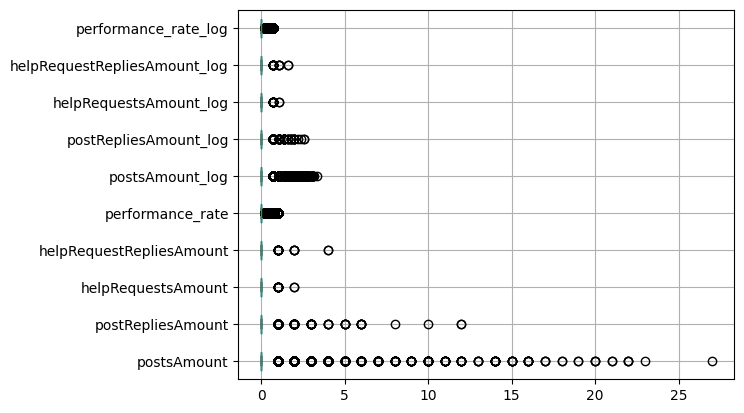

In [21]:
df_features.boxplot(vert=False)
plt.show()

In [22]:
# Encontrar todas as colunas que terminam com '_log'
log_cols = [col for col in df_features.columns if col.endswith('_log')]

# A partir das colunas de log, deduzir os nomes das colunas originais que as geraram
original_cols_to_drop = [col.replace('_log', '') for col in log_cols]

# A lista final de colunas é composta por TODAS as colunas, EXCETO as originais que foram transformadas
final_cols_to_keep = [col for col in df_features.columns if col not in original_cols_to_drop]


# --- Passo 2: Criar o DataFrame Final ---

train_set_final = df_features[final_cols_to_keep]

In [23]:
train_set_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   postsAmount_log               13856 non-null  float64
 1   postRepliesAmount_log         13856 non-null  float64
 2   helpRequestsAmount_log        13856 non-null  float64
 3   helpRequestRepliesAmount_log  13856 non-null  float64
 4   performance_rate_log          13856 non-null  float64
dtypes: float64(5)
memory usage: 541.4 KB


In [24]:
scaler = MinMaxScaler()
#feature_range=(-1, 1)
train_set_scaled_np = scaler.fit_transform(train_set_final)

In [25]:
train_set_scaled = pd.DataFrame(
train_set_scaled_np,
    columns=train_set_final.columns,
    index=train_set_final.index
)

In [27]:
train_set_final = train_set_scaled.copy()

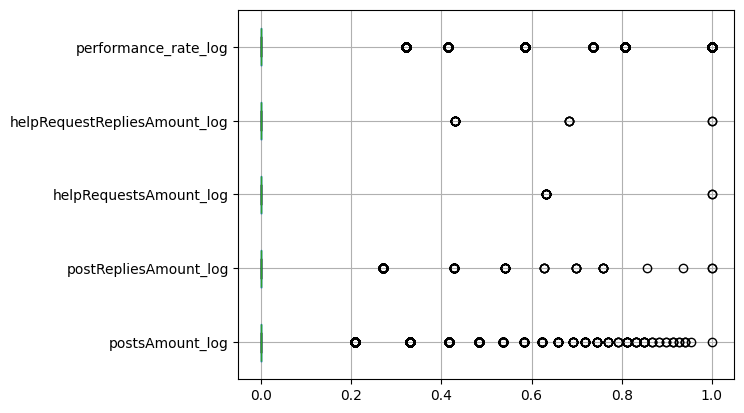

In [28]:
train_set_final.boxplot(vert=False)
plt.show()

In [30]:
# faixas de k para testar
k_range = range(2, 11)  # começa em 2 (não faz sentido silhouette com k=1)

# métricas
wcss = []
silhouette = []
calinski = []
davies = []
bic = []

for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_set_final)

    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(train_set_final, labels))
    calinski.append(calinski_harabasz_score(train_set_final, labels))
    davies.append(davies_bouldin_score(train_set_final, labels))

    # BIC com GaussianMixture
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(train_set_final)
    bic.append(gmm.bic(train_set_final))

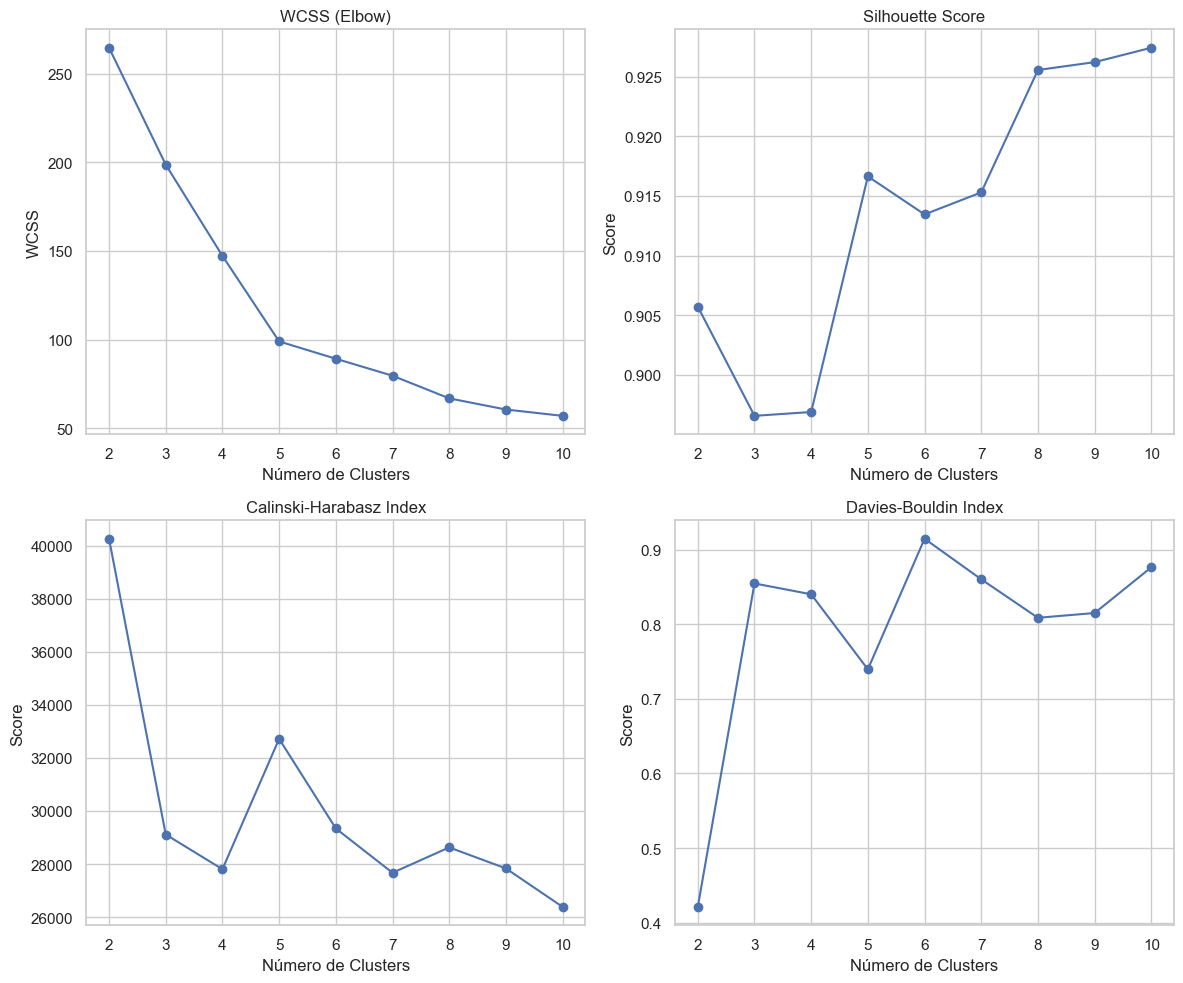

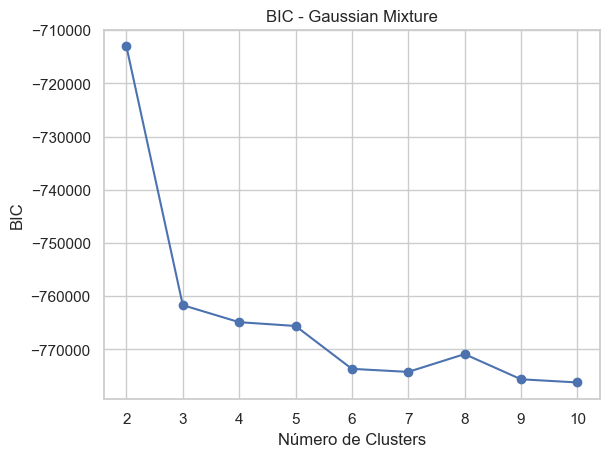

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))

# WCSS (cotovelo)
plt.subplot(2, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('WCSS (Elbow)')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# Silhouette
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Calinski-Harabasz
plt.subplot(2, 2, 3)
plt.plot(k_range, calinski, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Davies-Bouldin (quanto menor, melhor)
plt.subplot(2, 2, 4)
plt.plot(k_range, davies, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# BIC separado (opcional)
plt.figure()
plt.plot(k_range, bic, marker='o')
plt.title('BIC - Gaussian Mixture')
plt.xlabel('Número de Clusters')
plt.ylabel('BIC')
plt.show()


In [34]:
# Treinamento do K-Means
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(train_set_final)

In [36]:
tabela_contagem = pd.Series(y_kmeans).value_counts()

# Exibe a tabela final
print("Quantidade de itens por cluster:")
print(tabela_contagem)

Quantidade de itens por cluster:
0    12180
1      731
3      572
2      373
Name: count, dtype: int64


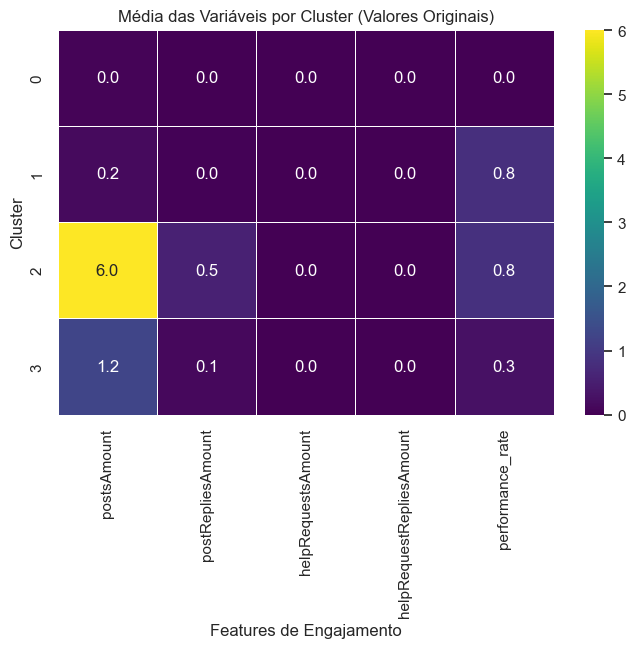

In [37]:
train_set['cluster'] = y_kmeans

# Calcular as médias por cluster
cluster_means = train_set.groupby('cluster').mean()

# Renomear colunas para o plot (removendo o sufixo '_log')
cluster_means_para_plotar = cluster_means.rename(columns=lambda c: c.replace('_log', ''))

# Passo 3: Plotar o Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    cluster_means_para_plotar,
    annot=True,
    fmt='.1f',
    cmap='viridis',
    linewidths=.5
)
plt.title('Média das Variáveis por Cluster (Valores Originais)', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xlabel('Features de Engajamento', fontsize=12)
plt.show()

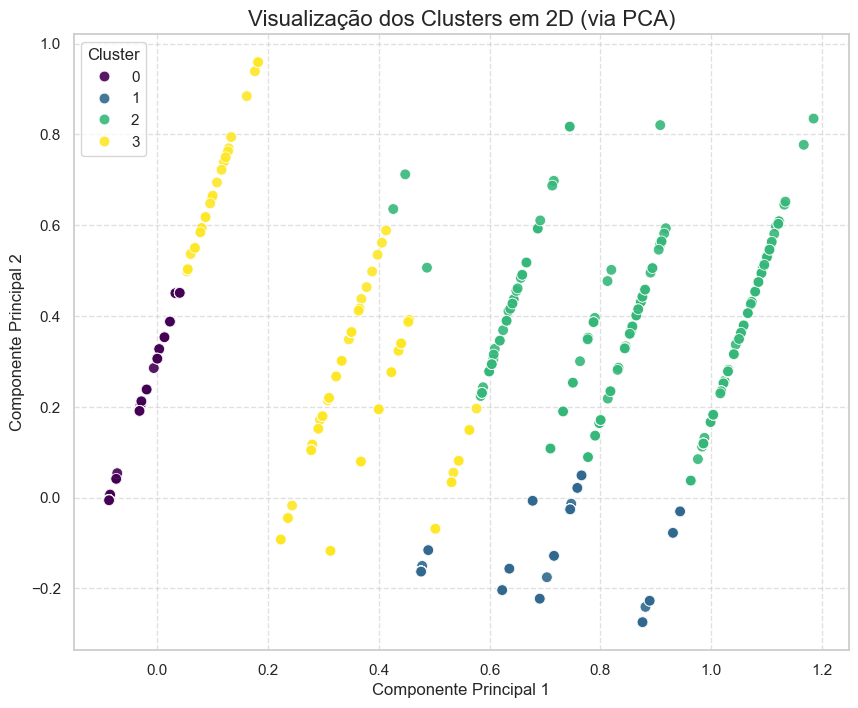

In [61]:
# Passo 1: Reduzir a dimensionalidade dos dados ESCALONADOS para 2D com PCA
pca = PCA(n_components=2)
dados_pca = pca.fit_transform(train_set_final)

# Passo 2: Criar um DataFrame para a visualização
df_pca = pd.DataFrame({
    'PCA1': dados_pca[:, 0],
    'PCA2': dados_pca[:, 1],
    'Cluster': y_kmeans
})

# Passo 3: Plotar o gráfico de dispersão
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_pca,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    s=60,
    alpha=0.9
)

plt.title('Visualização dos Clusters em 2D (via PCA)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

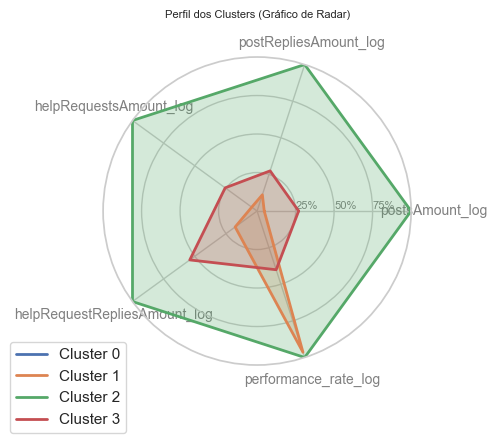

In [66]:
# Passo 1: Unir os dados originais e os clusters
df_analise = train_set_final.copy()
df_analise['Cluster'] = y_kmeans

# Passo 2: Calcular as médias de cada feature para cada cluster
centroids = df_analise.groupby('Cluster').mean()

# Passo 3: Escalonar os centroides para que fiquem na mesma escala (0 a 1) para o plot
scaler_radar = MinMaxScaler()
centroids_scaled = pd.DataFrame(scaler_radar.fit_transform(centroids), index=centroids.index, columns=centroids.columns)

# Passo 4: Código de plotagem do Gráfico de Radar
labels = centroids_scaled.columns
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], labels, color='grey', size=10)
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=8)
plt.ylim(0, 1)

# Plotar a linha de cada cluster
for i in range(len(centroids_scaled)):
    values = centroids_scaled.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

plt.title('Perfil dos Clusters (Gráfico de Radar)', size=8, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

--- Regras da Árvore de Decisão ---
|--- performance_rate_log <= 0.16
|   |--- postsAmount_log <= 0.51
|   |   |--- postRepliesAmount_log <= 0.14
|   |   |   |--- class: 0
|   |   |--- postRepliesAmount_log >  0.14
|   |   |   |--- class: 0
|   |--- postsAmount_log >  0.51
|   |   |--- class: 3
|--- performance_rate_log >  0.16
|   |--- performance_rate_log <= 0.50
|   |   |--- postsAmount_log <= 0.64
|   |   |   |--- class: 3
|   |   |--- postsAmount_log >  0.64
|   |   |   |--- class: 2
|   |--- performance_rate_log >  0.50
|   |   |--- postsAmount_log <= 0.27
|   |   |   |--- class: 1
|   |   |--- postsAmount_log >  0.27
|   |   |   |--- class: 2


--- Visualização da Árvore ---


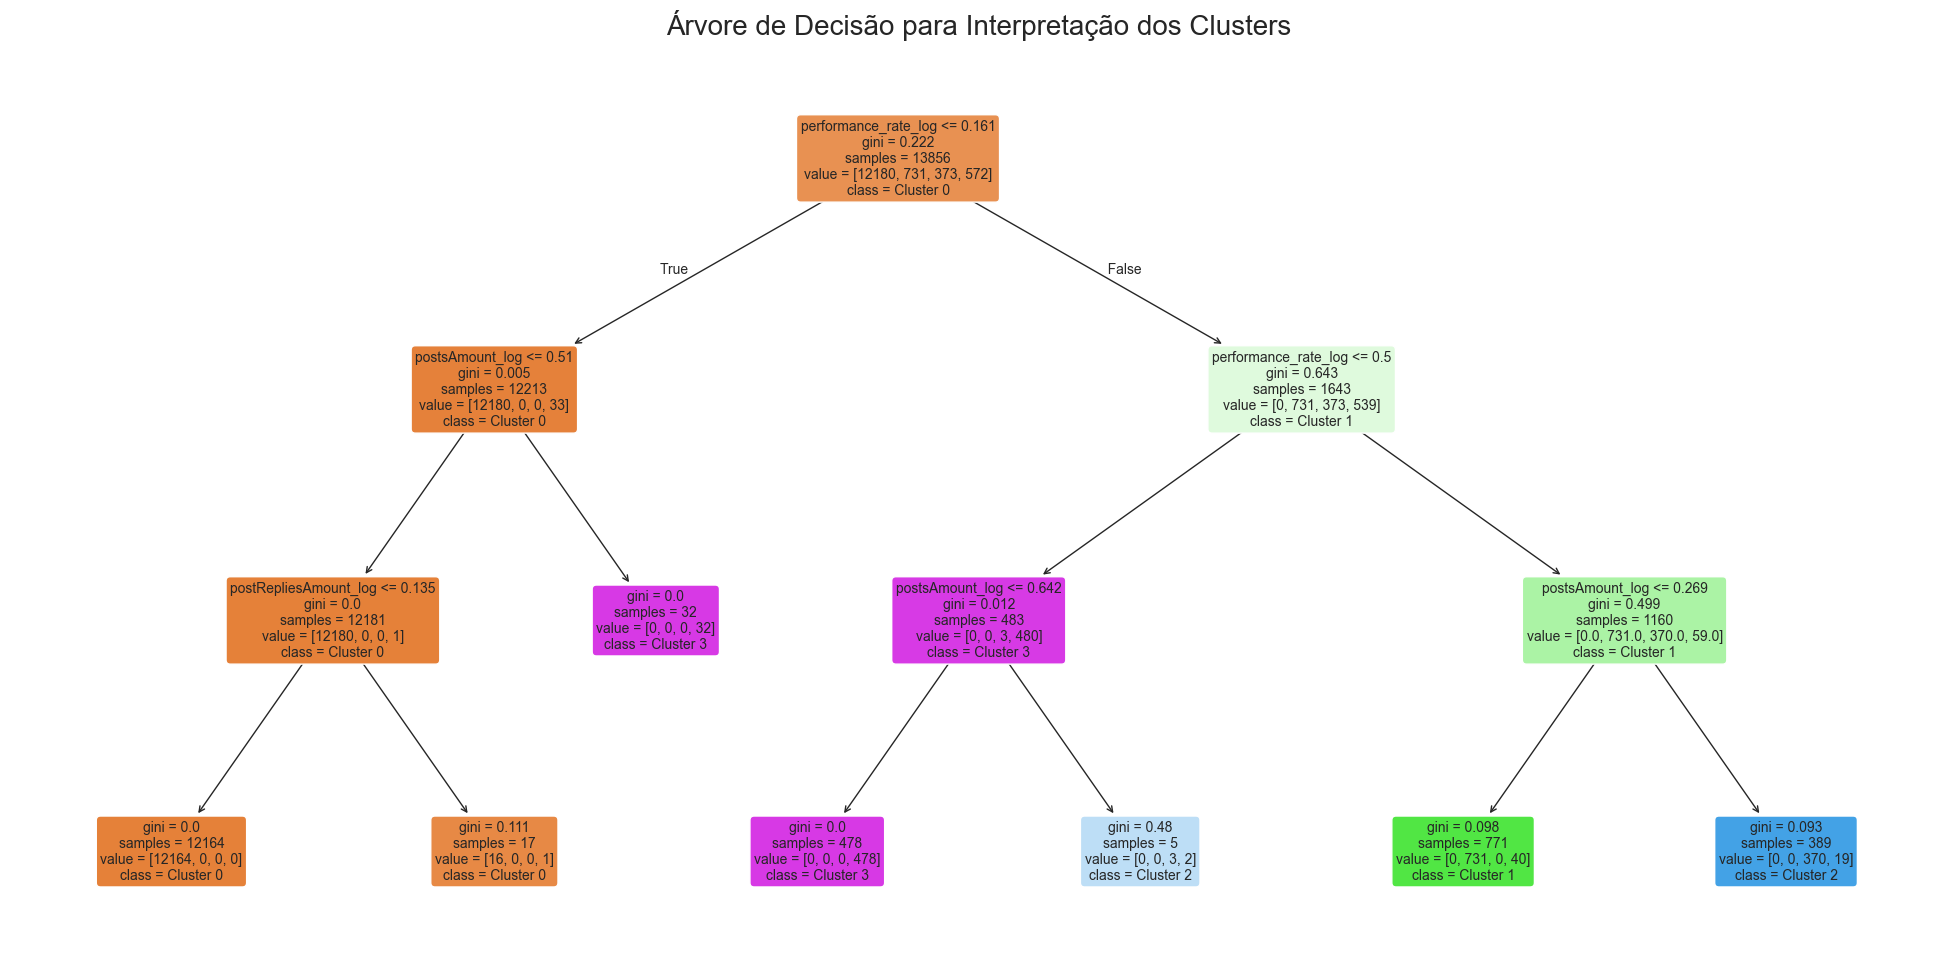

In [38]:
# --- 2. TREINAR A ÁRVORE DE DECISÃO ---

# Definir as features (X) e o alvo (y)
X = train_set_final
y = y_kmeans

# Inicializar o classificador.
# max_depth=3 significa que teremos no máximo 3 níveis de regras. É ótimo para interpretação.
# random_state garante que o resultado seja o mesmo toda vez.
arvore_de_decisao = DecisionTreeClassifier(max_depth=3, random_state=42)

# Treinar a árvore para aprender a mapear as features para os clusters
arvore_de_decisao.fit(X, y)


# --- 3. EXTRAIR E VISUALIZAR AS REGRAS ---

# Método 1: Extrair as regras como texto (muito útil!)
print("--- Regras da Árvore de Decisão ---")
nomes_features = X.columns.tolist()
regras_texto = export_text(arvore_de_decisao, feature_names=nomes_features)
print(regras_texto)


# Método 2: Visualizar a árvore de decisão (ainda mais intuitivo)
print("\n--- Visualização da Árvore ---")
# Nomes das classes para a legenda do gráfico
nomes_classes = [f'Cluster {i}' for i in sorted(np.unique(y))]

plt.figure(figsize=(25, 12))
plot_tree(
    arvore_de_decisao,
    feature_names=nomes_features,
    class_names=nomes_classes,
    filled=True,  # Colore os nós para indicar a classe majoritária
    rounded=True, # Deixa os nós com cantos arredondados
    fontsize=10
)
plt.title("Árvore de Decisão para Interpretação dos Clusters", fontsize=20)
plt.show()

In [39]:
# Passo 1: Adicionar os clusters e calcular as médias (centroides)
# train_set['cluster'] = y_kmeans
centroids = train_set.groupby('cluster').mean()

print("--- Médias das Variáveis Originais por Cluster ---")
print(centroids)
print("-" * 50)

# Passo 2: Ranquear os centroides para cada métrica
# ascending=False significa que o maior valor recebe o rank 1 (melhor)
centroids['rank_posts'] = centroids['postsAmount'].rank(method='first', ascending=False)
centroids['rank_performance'] = centroids['performance_rate'].rank(method='first', ascending=False)

# Criar scores combinados para facilitar a identificação
# Score Geral: soma dos ranks (quanto menor, melhor)
centroids['score_geral'] = centroids['rank_posts'] + centroids['rank_performance']

print("\n--- Centroides com Ranks e Scores ---")
print(centroids)
print("-" * 50)


# Passo 3: Aplicar as regras de negócio para identificar cada cluster
mapa_de_labels = {}

# "Engajamento excelente": Melhor rank em posts E melhor rank em performance.
# Portanto, terá o menor 'score_geral'.
id_excelente = centroids['score_geral'].idxmin()
mapa_de_labels[id_excelente] = "Engajamento excelente"

# "Não interagem": Pior rank em posts E pior rank em performance.
# Portanto, terá o maior 'score_geral'.
id_nao_interagem = centroids['score_geral'].idxmax()
mapa_de_labels[id_nao_interagem] = "Não interagem"

# Para os dois restantes, analisamos os ranks individuais
indices_restantes = [c for c in centroids.index if c not in mapa_de_labels]

cluster_restante_1 = centroids.loc[indices_restantes[0]]
cluster_restante_2 = centroids.loc[indices_restantes[1]]

# "Engajamento consistente": Rank de performance é MELHOR (menor) que o rank de posts.
# "Desempenho crítico": Rank de posts é MELHOR (menor) que o rank de performance.
if cluster_restante_1['rank_performance'] < cluster_restante_1['rank_posts']:
    mapa_de_labels[indices_restantes[0]] = "Engajamento consistente"
    mapa_de_labels[indices_restantes[1]] = "Desempenho crítico"
else:
    mapa_de_labels[indices_restantes[1]] = "Engajamento consistente"
    mapa_de_labels[indices_restantes[0]] = "Desempenho crítico"


print("\n--- Mapa de Labels Gerado Automaticamente ---")
# Ordena o dicionário pela chave (número do cluster) para facilitar a leitura
mapa_de_labels = dict(sorted(mapa_de_labels.items()))
print(mapa_de_labels)


# Passo 4: Aplicar o mapa gerado para criar a coluna final
train_set['categoria_interacao'] = train_set['cluster'].map(mapa_de_labels)

print("\n--- Contagem final das novas categorias ---")
print(train_set['categoria_interacao'].value_counts())

--- Médias das Variáveis Originais por Cluster ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.047619           0.001478            0.000657   
1           0.153215           0.045144            0.001368   
2           6.013405           0.541555            0.018767   
3           1.223776           0.125874            0.005245   

         helpRequestRepliesAmount  performance_rate  
cluster                                              
0                        0.001149          0.000000  
1                        0.004104          0.802668  
2                        0.021448          0.840929  
3                        0.012238          0.278555  
--------------------------------------------------

--- Centroides com Ranks e Scores ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.047619          

In [57]:
print(train_set['categoria_interacao'].value_counts())

categoria_interacao
Não interagem              12180
Engajamento consistente      731
Desempenho crítico           572
Engajamento excelente        373
Name: count, dtype: int64


In [55]:
dataset_clss = train_set.copy()
dataset_clss.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
0,0.0,0.0,0.0,0.0,0.0,0,Não interagem
1,0.0,0.0,0.0,0.0,0.0,0,Não interagem
2,0.0,0.0,0.0,0.0,0.0,0,Não interagem
3,0.0,0.0,0.0,0.0,0.0,0,Não interagem
4,0.0,0.0,0.0,0.0,0.0,0,Não interagem


In [56]:
dataset_clss.tail()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
13851,0.0,0.0,0.0,0.0,0.00,0,Não interagem
13852,3.0,0.0,0.0,0.0,0.00,0,Não interagem
13853,0.0,0.0,0.0,0.0,0.00,0,Não interagem
13854,0.0,0.0,0.0,0.0,0.00,0,Não interagem
13855,1.0,0.0,0.0,0.0,0.25,3,Desempenho crítico


In [42]:
dataset_clss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  float64
 1   postRepliesAmount         13856 non-null  float64
 2   helpRequestsAmount        13856 non-null  float64
 3   helpRequestRepliesAmount  13856 non-null  float64
 4   performance_rate          13856 non-null  float64
 5   cluster                   13856 non-null  int32  
 6   categoria_interacao       13856 non-null  object 
dtypes: float64(5), int32(1), object(1)
memory usage: 703.8+ KB


In [43]:
dataframe['categoria_engajamento'] = dataset_clss['categoria_interacao']

In [44]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,subject_name,lecture_name,period_start_date,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento
0,redu-digital,458,73,155,534,<NA>,<NA>,SPA,SILVIO FERREIRA PASSOS GONCALVES,SENAC-PE,...,None,None,2021-04-01,2021-06-30,0,0,0,0,0.0,Não interagem
1,redu-digital,688,73,155,534,<NA>,<NA>,SPA,JULIANNE SIQUEIRA PEREIRA,SENAC-PE,...,None,None,2020-10-01,2020-12-31,0,0,0,0,0.0,Não interagem
2,redu-digital,655,73,155,534,<NA>,<NA>,SPA,AIRTON HERMOGENES DO NASCIMENTO,SENAC-PE,...,None,None,2020-07-01,2020-09-30,0,0,0,0,0.0,Não interagem
3,redu-digital,684,73,155,534,<NA>,<NA>,SPA,IRENICE NOGUEIRA DOS SANTOS ALEX,SENAC-PE,...,None,None,2020-10-01,2020-12-31,0,0,0,0,0.0,Não interagem
4,redu-digital,684,73,155,534,<NA>,<NA>,SPA,IRENICE NOGUEIRA DOS SANTOS ALEX,SENAC-PE,...,None,None,2020-10-01,2020-12-31,0,0,0,0,0.0,Não interagem


In [45]:
dataframe['data_inicio'] = pd.to_datetime(data_inicio).date()
dataframe['data_fim'] = pd.to_datetime(data_fim).date()


# Passo 2: Adicionar a data de hoje como data da classificação
# A função date.today() captura a data atual em que o código é executado.
dataframe['data_classificacao'] = date.today()

In [46]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento,data_inicio,data_fim,data_classificacao
0,redu-digital,458,73,155,534,<NA>,<NA>,SPA,SILVIO FERREIRA PASSOS GONCALVES,SENAC-PE,...,2021-06-30,0,0,0,0,0.0,Não interagem,2020-01-01,2021-12-31,2025-08-29
1,redu-digital,688,73,155,534,<NA>,<NA>,SPA,JULIANNE SIQUEIRA PEREIRA,SENAC-PE,...,2020-12-31,0,0,0,0,0.0,Não interagem,2020-01-01,2021-12-31,2025-08-29
2,redu-digital,655,73,155,534,<NA>,<NA>,SPA,AIRTON HERMOGENES DO NASCIMENTO,SENAC-PE,...,2020-09-30,0,0,0,0,0.0,Não interagem,2020-01-01,2021-12-31,2025-08-29
3,redu-digital,684,73,155,534,<NA>,<NA>,SPA,IRENICE NOGUEIRA DOS SANTOS ALEX,SENAC-PE,...,2020-12-31,0,0,0,0,0.0,Não interagem,2020-01-01,2021-12-31,2025-08-29
4,redu-digital,684,73,155,534,<NA>,<NA>,SPA,IRENICE NOGUEIRA DOS SANTOS ALEX,SENAC-PE,...,2020-12-31,0,0,0,0,0.0,Não interagem,2020-01-01,2021-12-31,2025-08-29


In [47]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cliente                   13856 non-null  object 
 1   user_id                   13856 non-null  Int64  
 2   environment_id            13856 non-null  Int64  
 3   course_id                 13856 non-null  Int64  
 4   space_id                  13856 non-null  Int64  
 5   subject_id                0 non-null      Int64  
 6   lecture_id                0 non-null      Int64  
 7   NivelAgregacao            13856 non-null  object 
 8   user_name                 13856 non-null  object 
 9   environment_name          13856 non-null  object 
 10  course_name               13856 non-null  object 
 11  space_name                13856 non-null  object 
 12  subject_name              0 non-null      object 
 13  lecture_name              0 non-null      object 
 14  period

In [48]:
# # Define o nome completo da tabela de destino
# table_id = "viitra-redu.analytics.cubo_engajamento"

# # Prepara o DataFrame para envio
# df_to_load = dataframe.copy()
# df_to_load = df_to_load.rename(columns={
#     'categoria_interacao': 'categoria_engajamento',
#     'data_inicio_consulta': 'data_inicio',
#     'data_fim_consulta': 'data_fim'
# })

# # Converte as colunas de data para o tipo datetime do pandas, a forma mais robusta
# date_columns = ['data_inicio', 'data_fim', 'data_classificacao']
# for col in date_columns:
#     if col in df_to_load.columns:
#         df_to_load[col] = pd.to_datetime(df_to_load[col])

# # Garante que o DataFrame tenha apenas as colunas da tabela de destino
# schema_columns = [
#     'cliente', 'user_id', 'environment_id', 'course_id', 'space_id', 
#     'subject_id', 'lecture_id', 'NivelAgregacao', 'user_name', 
#     'environment_name', 'course_name', 'space_name', 'subject_name', 
#     'lecture_name', 'postsAmount', 'postRepliesAmount', 
#     'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate', 
#     'categoria_engajamento', 'data_inicio', 'data_fim', 'data_classificacao'
# ]
# df_to_load = df_to_load[schema_columns]

# # Configura o job para adicionar os dados (append)
# job_config = bigquery.LoadJobConfig(write_disposition="WRITE_APPEND")

# print(f"Iniciando o carregamento de {len(df_to_load)} registros para a tabela {table_id}...")

# try:
#     # Envia o DataFrame para o BigQuery e aguarda a conclusão
#     load_job = client.load_table_from_dataframe(
#         df_to_load, table_id, job_config=job_config
#     )
#     load_job.result()
#     print("Carregamento concluído com sucesso!")
#     print(f"Foram carregadas {load_job.output_rows} linhas.")

# except Exception as e:
#     print(f"Ocorreu um erro durante o carregamento: {e}")
#     if 'load_job' in locals() and load_job.errors:
#         print("Detalhes do erro do BigQuery:", load_job.errors)

# # Executa uma consulta de verificação no BigQuery
# print("\nVerificação dos dados inseridos hoje no BigQuery:")
# query = f"""
#     SELECT data_classificacao, COUNT(1) as total_registros
#     FROM `{table_id}`
#     WHERE data_classificacao = CURRENT_DATE('America/Sao_Paulo')
#     GROUP BY 1
# """
# results_df = client.query(query).to_dataframe()
# print(results_df)

In [49]:
#Treinamento supervisionado 

In [50]:
df = dataframe.copy()

In [51]:
# 1. Crie uma cópia do DataFrame para análise
df_analysis = df.copy()

# 2. Codifique a variável-alvo para um formato numérico para calcular a correlação
le = LabelEncoder()
df_analysis['target_encoded'] = le.fit_transform(df_analysis['categoria_engajamento'])

# 3. Defina as features que você usou no modelo
features = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate']

# 4. Calcule a correlação de cada feature com o alvo codificado
correlations = df_analysis[features + ['target_encoded']].corr()

print("Correlação das Features com a Variável-Alvo:")
print(correlations['target_encoded'].sort_values(ascending=False))

Correlação das Features com a Variável-Alvo:
target_encoded              1.000000
helpRequestsAmount         -0.031559
helpRequestRepliesAmount   -0.038614
postRepliesAmount          -0.132962
postsAmount                -0.258094
performance_rate           -0.714285
Name: target_encoded, dtype: float64


In [52]:
# =============================================================================
# PASSO 2: DEFINIÇÃO DAS FEATURES E DIVISÃO EM TREINO, VALIDAÇÃO E TESTE
# =============================================================================
features = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate']
target = 'categoria_engajamento'
X = df[features]
y = df[target]

# Divisão dos dados (em formato de texto para 'y')
X_train_full, X_test, y_train_full_text, y_test_text = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train_text, y_val_text = train_test_split(
    X_train_full, y_train_full_text, test_size=0.25, random_state=42, stratify=y_train_full_text
)


In [53]:
# =============================================================================
# PASSO 3: PRÉ-PROCESSAMENTO COM PIPELINE (CORREÇÃO)
# =============================================================================
# Criamos um pipeline que executa a imputação e o escalonamento em sequência
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- APRENDENDO (fit) SOMENTE com os dados de TREINO ---
# O pipeline aprende as regras de imputação e escalonamento de uma só vez
preprocessor.fit(X_train)
print("Pipeline de pré-processamento treinado.")

# --- APLICANDO (transform) as regras aprendidas em TODOS os conjuntos ---
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
print("Todos os conjuntos de features foram pré-processados pelo pipeline.")

# --- Codificação do Alvo (Label Encoding) - Feito separadamente ---
le = LabelEncoder()
le.fit(y_train_text)
y_train = le.transform(y_train_text)
y_val = le.transform(y_val_text)
y_test = le.transform(y_test_text)
target_classes = le.classes_
print("-" * 40)

Pipeline de pré-processamento treinado.
Todos os conjuntos de features foram pré-processados pelo pipeline.
----------------------------------------


In [54]:
# =============================================================================
# PASSO 4: BALANCEAMENTO DE CLASSES (APENAS NO CONJUNTO DE TREINO)
# =============================================================================
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
print("Conjunto de treino balanceado com SMOTE.")
print("-" * 40)

# =============================================================================
# PASSO 5 E 6: OTIMIZAÇÃO, TREINO E AVALIAÇÃO (Sem alterações aqui)
# =============================================================================
# (O restante do código para otimização e avaliação permanece o mesmo)

# OTIMIZAÇÃO MANUAL...
param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10, 15], 'min_samples_leaf': [5, 10, 15]}
best_accuracy = 0.0
best_params = {}

for n_est in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        for leaf in param_grid['min_samples_leaf']:
            model = RandomForestClassifier(
                n_estimators=n_est, max_depth=depth, min_samples_leaf=leaf,
                random_state=42, n_jobs=-1
            )
            model.fit(X_train_balanced, y_train_balanced)
            accuracy = model.score(X_val_processed, y_val)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'n_estimators': n_est, 'max_depth': depth, 'min_samples_leaf': leaf}
print(f"Melhores parâmetros encontrados: {best_params}")
print("-" * 40)
printf

Conjunto de treino balanceado com SMOTE.
----------------------------------------
Melhores parâmetros encontrados: {'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 5}
----------------------------------------


NameError: name 'printf' is not defined

AVALIAÇÃO FINAL NO CONJUNTO DE TESTE

                         precision    recall  f1-score   support

     Desempenho crítico       0.97      1.00      0.99       146
Engajamento consistente       1.00      1.00      1.00       106
  Engajamento excelente       1.00      0.95      0.97        77
          não interagem       1.00      1.00      1.00      2443

               accuracy                           1.00      2772
              macro avg       0.99      0.99      0.99      2772
           weighted avg       1.00      1.00      1.00      2772



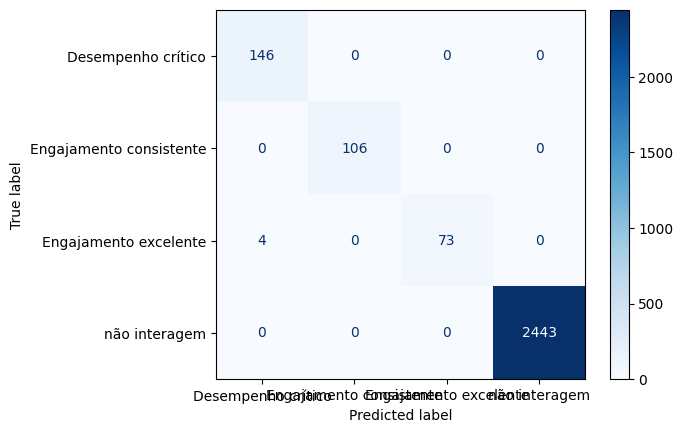

In [ ]:
# AVALIAÇÃO FINAL...
final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train_balanced, y_train_balanced)
y_pred = final_model.predict(X_test_processed)
print("AVALIAÇÃO FINAL NO CONJUNTO DE TESTE\n")
print(classification_report(y_test, y_pred, target_names=target_classes))
disp = ConfusionMatrixDisplay.from_estimator(final_model, X_test_processed, y_test, display_labels=target_classes, cmap=plt.cm.Blues)
plt.show()


Gerando a visualização de uma das árvores de decisão do modelo...


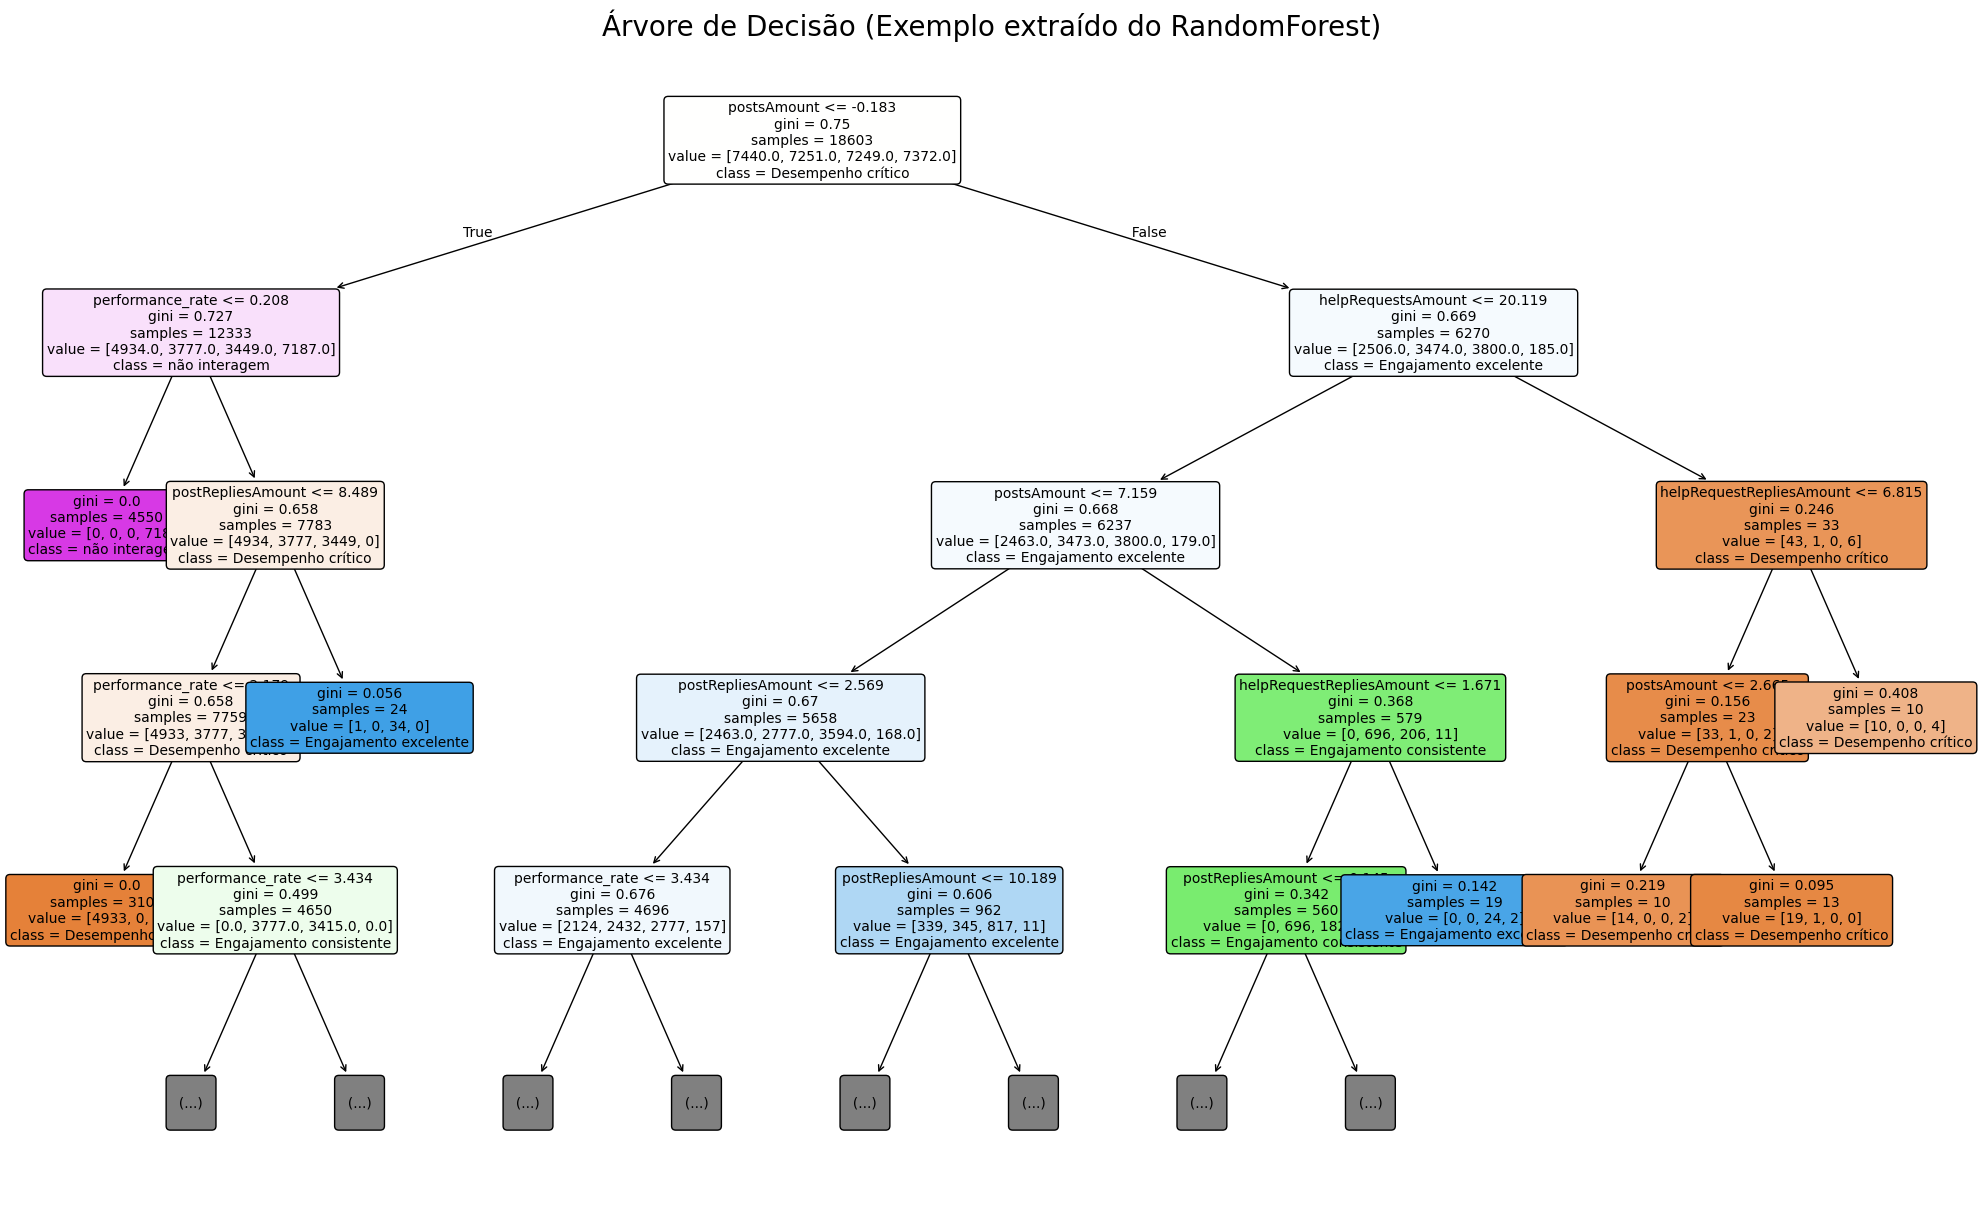

In [ ]:
# =============================================================================
# PASSO 7: VISUALIZAÇÃO DA ÁRVORE DE REGRAS
# =============================================================================
print("\nGerando a visualização de uma das árvores de decisão do modelo...")

# 1. Selecionar uma única árvore da floresta (vamos pegar a primeira, índice 0)
tree_to_plot = final_model.estimators_[0]


# 2. Configurar a figura para a visualização
plt.figure(figsize=(25, 15)) # Aumentar o tamanho para melhor legibilidade

# 3. Gerar o gráfico da árvore
plot_tree(tree_to_plot, 
          feature_names=features,  # Nomes das features que definimos no início
          class_names=target_classes, # Nomes das classes ('Alto', 'Baixo', 'Medio')
          filled=True,      # Colore os nós para indicar a classe majoritária
          rounded=True,     # Deixa os nós com cantos arredondados
          fontsize=10,      # Tamanho da fonte
          max_depth=4)      # Limita a profundidade para não poluir o gráfico

plt.title("Árvore de Decisão (Exemplo extraído do RandomForest)", fontsize=20)
plt.show()


In [ ]:
# =============================================================================
# PASSO 8: EXTRAÇÃO DAS REGRAS DA ÁRVORE EM FORMATO DE TEXTO
# =============================================================================

# Selecionamos uma única árvore para extrair as regras (ex: a 5ª árvore)
# É bom testar algumas (ex: 0, 5, 10) para ver qual tem uma estrutura interessante
tree_for_rules = final_model.estimators_[5]
tree_structure = tree_for_rules.tree_

# Pega os nomes das features e classes que já definimos antes
feature_names = features
class_names = target_classes # Da variável le.classes_

def print_decision_rules(tree, feature_names, class_names, scaler):
    """
    Função recursiva para imprimir as regras de uma árvore de decisão.
    """
    
    # Pega os atributos da estrutura da árvore
    children_left = tree.children_left
    children_right = tree.children_right
    feature_idx = tree.feature
    thresholds = tree.threshold

    def recurse(node_id, depth):
        # Cria a indentação baseada na profundidade da árvore
        indent = "|   " * depth
        
        # Verifica se o nó é um nó de decisão (não é uma folha)
        if children_left[node_id] != children_right[node_id]:
            # Pega o nome e o limiar (threshold) da regra
            name = feature_names[feature_idx[node_id]]
            threshold = thresholds[node_id]

            # --- TRADUÇÃO DO VALOR ESCALONADO PARA O ORIGINAL ---
            # Cria um array com o número certo de features (preenchido com 0)
            scaled_value_array = np.zeros(len(feature_names))
            # Coloca o valor do threshold na posição correta da feature
            scaled_value_array[feature_idx[node_id]] = threshold
            # Desfaz a escala para obter o valor original
            original_threshold = scaler.inverse_transform([scaled_value_array])[0][feature_idx[node_id]]
            # ----------------------------------------------------

            # Imprime a regra para a ramificação da esquerda (condição VERDADEIRA)
            print(f"{indent}|--- {name} <= {original_threshold:.2f}")
            recurse(children_left[node_id], depth + 1)

            # Imprime a regra para a ramificação da direita (condição FALSA)
            print(f"{indent}|--- {name} > {original_threshold:.2f}")
            recurse(children_right[node_id], depth + 1)
        
        # Se o nó for uma folha (não tem mais filhos)
        else:
            # Pega a classe prevista
            class_distribution = tree.value[node_id][0]
            predicted_class_index = np.argmax(class_distribution)
            predicted_class_name = class_names[predicted_class_index]
            print(f"{indent}|--- class: {predicted_class_name} (índice {predicted_class_index})")

    # Inicia a recursão a partir do nó raiz (id=0, profundidade=0)
    print("--- Regras da Árvore de Decisão (Valores Originais) ---")
    recurse(0, 0)


# Chama a função para imprimir as regras.
# Precisamos passar a estrutura da árvore, os nomes, e o 'scaler' para traduzir os valores.
print_decision_rules(tree_structure, feature_names, class_names, scaler)

--- Regras da Árvore de Decisão (Valores Originais) ---
|--- performance_rate <= 0.21
|   |--- class: não interagem (índice 3)
|--- performance_rate > 0.21
|   |--- performance_rate <= 1.84
|   |   |--- postRepliesAmount <= 78.38
|   |   |   |--- class: Desempenho crítico (índice 0)
|   |   |--- postRepliesAmount > 78.38
|   |   |   |--- performance_rate <= 1.79
|   |   |   |   |--- class: Desempenho crítico (índice 0)
|   |   |   |--- performance_rate > 1.79
|   |   |   |   |--- class: Desempenho crítico (índice 0)
|   |--- performance_rate > 1.84
|   |   |--- postsAmount <= 211.84
|   |   |   |--- performance_rate <= 3.43
|   |   |   |   |--- class: Engajamento excelente (índice 2)
|   |   |   |--- performance_rate > 3.43
|   |   |   |   |--- class: Engajamento consistente (índice 1)
|   |   |--- postsAmount > 211.84
|   |   |   |--- postRepliesAmount <= 0.22
|   |   |   |   |--- performance_rate <= 3.43
|   |   |   |   |   |--- class: Engajamento excelente (índice 2)
|   |   |   |  